**import packages**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import warnings 
warnings.filterwarnings("ignore")
import time

# DATA PREPARATION
## Load the training data and test data

In [2]:
column_name = ['engine_id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
               's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
               's15', 's16', 's17', 's18', 's19', 's20', 's21']
train_FD001 = pd.read_table("./CMAPSSData/train_FD001.txt", header=None, delim_whitespace=True)
train_FD001.columns = column_name
# Test 文件中的cycle数 并不是到死的
test_FD001 = pd.read_table("./CMAPSSData/test_FD001.txt", header=None, delim_whitespace=True)
test_FD001.columns = column_name

# load RUL data 真正的最后循环数存放在这里
RUL_FD001 = pd.read_table("./CMAPSSData/RUL_FD001.txt", header=None, delim_whitespace=True)

In [3]:
train_FD001.head()

,engine_id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


## standard normalization
<span class="mark">train 和 test 集一定都要 正则化，方法就是减去平均值除以方差。
需要注意的是，test集上，正则化用的是training数据的平均值和方差。只能用训练数据集上的信息，test集上的一切信息都不能用。</span>

In [4]:
#### standard normalization ####

# Training 因为前两列是没有用的 engine_id cycle
mean = train_FD001.iloc[:, 2:].mean()
std = train_FD001.iloc[:, 2:].std()
std.replace(0, 1, inplace=True)
train_FD001.iloc[:, 2:] = (train_FD001.iloc[:, 2:] - mean) / std

# Testing
mean = test_FD001.iloc[:, 2:].mean()
std = test_FD001.iloc[:, 2:].std()
std.replace(0, 1, inplace=True)
test_FD001.iloc[:, 2:] = (test_FD001.iloc[:, 2:] - mean) / std

## Compute the RUL

'''
    Piecewise linear function with zero gradient and unit gradient
    
            ^
            |
    MAXLIFE |-----------
            |            \
            |             \
            |              \
            |               \
            |                \
            |----------------------->
    '''
    因为从下图的可视化可以看出，所有的传感器值的变化并不是一个逐渐降低的过程。而是先保持平稳，再出现逐渐变化的趋势。
    也就是说，在刚开始机器的状态并没有开始下滑。而是到一个临界点的时候，才开始下滑。
    那么临界点之前的数据，如果强行默认下滑，可能不好学习。
    临街点的值是通过可视化，凭借经验定义的，大部分都是在倒数120周期的时候开始变化。
<span class="mark">其实可以通过wavelet transformation 降噪，得出变化点的开头，不同数据集。定义不同的临界点！</span>

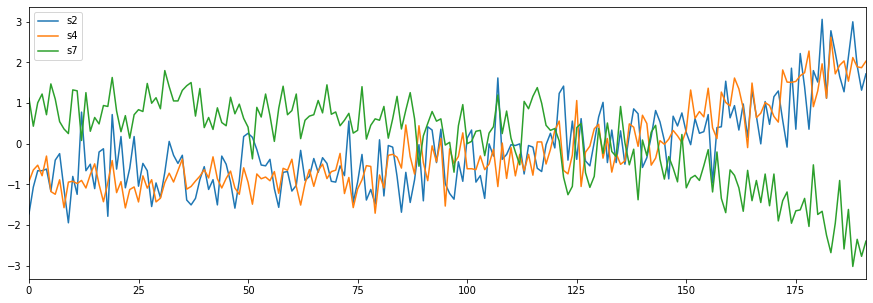

In [5]:
train_FD001[train_FD001["engine_id"]==1][["s2","s4","s7"]].plot(figsize=(15,5));

### Training

In [6]:
id='engine_id'
# 这个是自己定义的， 拐点在120 ，  120之前视为一样
MAXLIFE = 120
rul = [] # 会逐渐装满所有id的RUL
for _id in set(train_FD001[id]):
    trainFD001_of_one_id =  train_FD001[train_FD001[id] == _id]
    cycle_list = trainFD001_of_one_id['cycle'].tolist()
    # 因为这里是run to end ,所以最大cycle数是确定的
    max_cycle = max(cycle_list)
    # 计算出临界点的位置，没到达临界点的时候，全部保存MAXLIFE，到达临界点的时候，逐点下降！
    knee_point = max_cycle - MAXLIFE
    kink_RUL = []
    for i in range(0, len(cycle_list)):
        # 
        if i < knee_point:
            kink_RUL.append(MAXLIFE)
        else:
            tmp = kink_RUL[i - 1] - 1
            kink_RUL.append(tmp)
    # 每跑完一个id就添加到最后总的rul列表中
    rul.extend(kink_RUL)

train_FD001["RUL"] = rul

# training_engine_id = train_FD001['engine_id']
# train_FD001 = train_FD001.drop('engine_id', 1)
# train_FD001 = train_FD001.drop('cycle', 1)

### Testing
TEST数据集和训练数据集是不一样的，RUL是定义好了的。已经读在了RUL_FD001 dataframe里面

In [7]:
id='engine_id'
rul = []
for _id in set(test_FD001[id]):
    # 真实的RUL， 也就是测试数据最后一个周期所对应的RUL
    true_rul = int(RUL_FD001.iloc[_id - 1])
    testFD001_of_one_id =  test_FD001[test_FD001[id] == _id]
    cycle_list = testFD001_of_one_id['cycle'].tolist()
    # 那么总的生命周期数=训练集的已有周期数+最后剩下的周期数
    max_cycle = max(cycle_list) + true_rul
    knee_point = max_cycle - MAXLIFE
    kink_RUL = []
    for i in range(0, len(cycle_list)):
        if i < knee_point:
            kink_RUL.append(MAXLIFE)
        else:
            tmp = kink_RUL[i - 1] - 1
            kink_RUL.append(tmp)    

    rul.extend(kink_RUL)

test_FD001["RUL"] = rul

    训练数据的格式应该是[batch, timesteps, windowsize, numberofsensor] (这里没有考虑channel的维度）
    如果timesteps设置为10，窗口大小设置为24
    那么一个训练集最短至少要有33
    测试集的输入尺寸除了batch,都要保持和训练集的一致
<span class="mark">所以timesteps和窗口大小不能随意定</span>

In [8]:
min_shape = np.min([i[0] for i in train_FD001.groupby("engine_id").apply(np.shape).values])
print("训练集中最小的长度是：",min_shape)

训练集中最小的长度是： 128


In [9]:
min_shape = np.min([i[0] for i in test_FD001.groupby("engine_id").apply(np.shape).values])
print("测试集中最小的长度是：",min_shape)

测试集中最小的长度是： 31


In [10]:
# test_FD001 = test_FD001.drop('engine_id', 1)
# test_FD001 = test_FD001.drop('cycle', 1)
# test_values = test_FD001.values

    这时候 train_FD001 和 test_FD001结构是一样的，第一列是id，中间24个传感器数据，最后一列是 rul

In [11]:
train_FD001[train_FD001["engine_id"]==1].head()

,engine_id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.315972,-1.372920,0.0,0.999976,-1.721684,-0.134252,-0.925914,0.999976,...,-1.058865,-0.269065,-0.603801,0.999976,-0.781691,0.0,0.0,1.348460,1.194398,120
1,1,2,0.872701,-1.031695,0.0,0.999976,-1.061754,0.211523,-0.643710,0.999976,...,-0.363637,-0.642829,-0.275845,0.999976,-0.781691,0.0,0.0,1.016503,1.236892,120
2,1,3,-1.961827,1.015652,0.0,0.999976,-0.661797,-0.413156,-0.525940,0.999976,...,-0.919819,-0.551616,-0.649128,0.999976,-2.073044,0.0,0.0,0.739873,0.503411,120
3,1,4,0.324083,-0.008022,0.0,0.999976,-0.661797,-1.261284,-0.784812,0.999976,...,-0.224592,-0.520163,-1.971617,0.999976,-0.781691,0.0,0.0,0.352590,0.777773,120
4,1,5,-0.864590,-0.690471,0.0,0.999976,-0.621801,-1.251498,-0.301511,0.999976,...,-0.780774,-0.521736,-0.339837,0.999976,-0.136014,0.0,0.0,0.463242,1.059526,120


### Plot a figure

In [12]:
test_FD001.head()

,engine_id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,1.049255,1.005889,0.0,0.999962,1.359224,-0.561473,-0.975637,0.999962,...,-0.720563,-1.314981,-0.711632,0.999962,-0.463388,0.0,0.0,-0.229400,0.448849,120
1,1,2,-1.220702,-1.034715,0.0,0.999962,-1.908429,0.070113,-1.392783,0.999962,...,-0.193640,0.065974,-1.569977,0.999962,0.347263,0.0,0.0,0.899900,0.664017,120
2,1,3,0.141273,0.325687,0.0,0.999962,-0.037635,-0.231689,-0.507656,0.999962,...,-0.720563,-0.868403,0.629316,0.999962,0.347263,0.0,0.0,1.323387,0.961211,120
3,1,4,1.911839,-0.014413,0.0,0.999962,-0.087523,-0.795320,0.251878,0.999962,...,-0.369281,-0.593586,-1.177000,0.999962,-1.274039,0.0,0.0,0.758737,0.451227,120
4,1,5,0.640663,-0.014413,0.0,0.999962,0.087085,-0.181722,-0.420938,0.999962,...,-0.720563,-0.923367,-0.784023,0.999962,-2.084690,0.0,0.0,0.688156,0.918415,120


training (20631, 24) (20631,)
testing (13096, 24) (13096,)


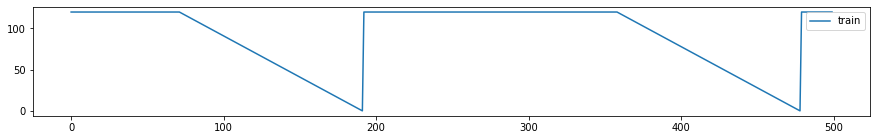

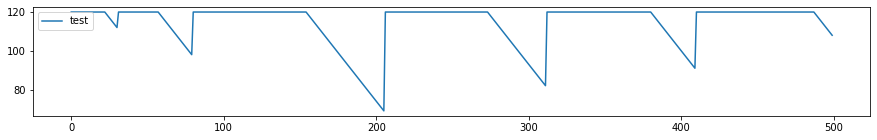

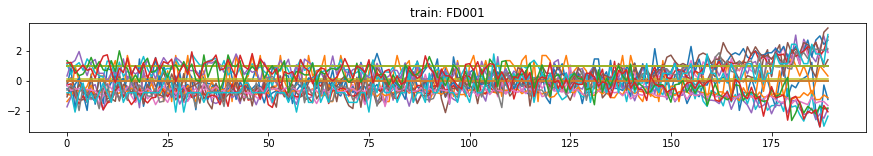

In [13]:
training_data = train_FD001.values
testing_data = test_FD001.values

x_train = training_data[:, 2:-1]
y_train = training_data[:, -1]
print("training", x_train.shape, y_train.shape)

x_test = testing_data[:, 2:-1]
y_test = testing_data[:, -1]
print("testing", x_test.shape, y_test.shape)
# 训练数据集 前面500个数据点所对应的rul 由图中可以看出  都是到零的了
plt.figure(figsize=(15,2))
plt.plot(y_train[:500], label="train")
plt.legend()
plt.figure(figsize=(15,2))
# 测试数据中前500个数据点对应的tul  可以看到结尾数据的rul 都不是中间
plt.plot(y_test[:500], label="test")
plt.legend()
plt.figure(figsize=(15,2))
plt.plot(x_train[:190])
plt.title("train: FD00" + str(1))
# 训练数据第一个id的 24个senor的值 可以通过在x轴坐标100的位置 序列的一些 趋势

plt.show()

# Convolutional NN

In [14]:
def batch_generator(training_data, sequence_length=15, window_size = 15):
    """
    Generator function for creating random batches of training-data for many to many models
    """
    engine_ids = list(training_data["engine_id"].unique())
    temp = training_data.copy()
    # 把 每一段后一截给截掉，获取能够跑的index
    for id_ in engine_ids:
        indexes = temp[temp["engine_id"] == id_].index
        traj_data = temp.loc[indexes]
        # cutoff_cycle 记录下这以后的index就不满足 序列大小的需求的
        cutoff_cycle = max(traj_data['cycle']) - sequence_length - window_size + 1
        
        if cutoff_cycle<0:
            # 也就是步长和窗口大小已经大于了该机器的已有周期数，全部都得扔掉
            drop_range = indexes
            print("有一些数据直接就被抛弃了，请合理设置窗口大小和时间长度")
        else:
            cutoff_cycle_index = traj_data['cycle'][traj_data['cycle'] == cutoff_cycle+2].index
            drop_range = list(range(cutoff_cycle_index[0], indexes[-1] + 1))
            
        temp.drop(drop_range, inplace=True)
    indexes = temp.index
    del temp
    

    x_shape = (len(indexes), sequence_length, window_size, 24)
    x_batch = np.zeros(shape=x_shape, dtype=np.float32)
    y_shape = (len(indexes), sequence_length)
    y_batch = np.zeros(shape=y_shape, dtype=np.float32)
    
    # 第一个数据集
    alt_index = indexes[0]
    for batch_index, index in enumerate(indexes):
        # 因为对齐的原因，都减去了1
        y_batch[batch_index] = training_data.iloc[index+window_size-1:index+window_size-1+sequence_length,-1].values
        
        # 本来应该下面这个 for 循环的，但是考虑到循环的嵌套，跑太久了，而且窗口序列之间又有重复，那么减少循环的次数
        # for seq in range(sequence_length):
            # x_batch[index,seq] = training_data.iloc[idx+seq:idx+seq + window_size, 2:-1].values
        
        if index-alt_index==1 and batch_index!=0:
            temp_window = training_data.iloc[index+sequence_length-1:index+sequence_length-1 + window_size, 2:-1].values.reshape(1,window_size,-1)
            x_batch[batch_index] = np.concatenate((x_batch[batch_index-1][1:],temp_window))
        else:
            for seq in range(sequence_length):
                x_batch[batch_index][seq] = training_data.iloc[index+seq:index+seq + window_size, 2:-1].values
        alt_index = index
    # 如果数据集过于大的情况下 应该使用yield来构成 循环的 generator、
    
    return x_batch, y_batch

# Training CNNLSTM

初始化seed

In [15]:
import tensorflow as tf

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed
#from tensorflow.keras.layers.convolutional import Conv3D
#from tensorflow.keras.layers.convolutional_recurrent import ConvLSTM2D
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

In [17]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

from tensorflow.python.keras import activations
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import constraints
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.engine.base_layer import Layer
from tensorflow.python.keras.layers.recurrent import DropoutRNNCellMixin
from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.ops import array_ops
from tensorflow.python.util.tf_export import keras_export
from tensorflow.compat.v2.keras.layers import ConvLSTM2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed
#from tensorflow.keras.layers.convolutional import Conv3D
#from tensorflow.keras.layers.convolutional_recurrent import ConvLSTM2D
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.python.keras.layers.recurrent import RNN
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.keras.engine.input_spec import InputSpec
from tensorflow.python.keras.layers.recurrent import _standardize_args
from tensorflow.python.keras.utils import generic_utils

# conv_lstm

In [18]:
x_batch, y_batch =batch_generator(train_FD001,sequence_length=15,window_size = 15)
# 这里需要把输入数据增加一个channel层数
x_batch = np.expand_dims(x_batch, axis=4)
y_batch = np.expand_dims(y_batch, axis=2)

In [19]:
class ConvRNN2D(RNN):

  def __init__(self,
               cell,
               return_sequences=False,
               return_state=False,
               go_backwards=False,
               stateful=False,
               unroll=False,
               **kwargs):
    if unroll:
      raise TypeError('Unrolling isn\'t possible with '
                      'convolutional RNNs.')
    if isinstance(cell, (list, tuple)):
      # The StackedConvRNN2DCells isn't implemented yet.
      raise TypeError('It is not possible at the moment to'
                      'stack convolutional cells.')
    super(ConvRNN2D, self).__init__(cell,
                                    return_sequences,
                                    return_state,
                                    go_backwards,
                                    stateful,
                                    unroll,
                                    **kwargs)
    self.input_spec = [InputSpec(ndim=5)]
    self.states = None
    self._num_constants = None

  @tf_utils.shape_type_conversion
  def compute_output_shape(self, input_shape):
    if isinstance(input_shape, list):
      input_shape = input_shape[0]

    cell = self.cell
    if cell.data_format == 'channels_first':
      rows = input_shape[3]
      cols = input_shape[4]
    elif cell.data_format == 'channels_last':
      rows = input_shape[2]
      cols = input_shape[3]
    rows = conv_utils.conv_output_length(rows,
                                         cell.kernel_size[0],
                                         padding=cell.padding,
                                         stride=cell.strides[0],
                                         dilation=cell.dilation_rate[0])
    cols = conv_utils.conv_output_length(cols,
                                         cell.kernel_size[1],
                                         padding=cell.padding,
                                         stride=cell.strides[1],
                                         dilation=cell.dilation_rate[1])

    if cell.data_format == 'channels_first':
      output_shape = input_shape[:2] + (cell.filters, rows, cols)
    elif cell.data_format == 'channels_last':
      output_shape = input_shape[:2] + (rows, cols, cell.filters)

    if not self.return_sequences:
      output_shape = output_shape[:1] + output_shape[2:]

    if self.return_state:
      output_shape = [output_shape]
      if cell.data_format == 'channels_first':
        output_shape += [(input_shape[0], cell.filters, rows, cols)
                         for _ in range(2)]
      elif cell.data_format == 'channels_last':
        output_shape += [(input_shape[0], rows, cols, cell.filters)
                         for _ in range(2)]
    return output_shape

  @tf_utils.shape_type_conversion
  def build(self, input_shape):
    # Note input_shape will be list of shapes of initial states and
    # constants if these are passed in __call__.
    if self._num_constants is not None:
      constants_shape = input_shape[-self._num_constants:]  # pylint: disable=E1130
    else:
      constants_shape = None

    if isinstance(input_shape, list):
      input_shape = input_shape[0]

    batch_size = input_shape[0] if self.stateful else None
    self.input_spec[0] = InputSpec(shape=(batch_size, None) + input_shape[2:5])

    # allow cell (if layer) to build before we set or validate state_spec
    if isinstance(self.cell, Layer):
      step_input_shape = (input_shape[0],) + input_shape[2:]
      if constants_shape is not None:
        self.cell.build([step_input_shape] + constants_shape)
      else:
        self.cell.build(step_input_shape)

    # set or validate state_spec
    if hasattr(self.cell.state_size, '__len__'):
      state_size = list(self.cell.state_size)
    else:
      state_size = [self.cell.state_size]

    if self.state_spec is not None:
      # initial_state was passed in call, check compatibility
      if self.cell.data_format == 'channels_first':
        ch_dim = 1
      elif self.cell.data_format == 'channels_last':
        ch_dim = 3
      if [spec.shape[ch_dim] for spec in self.state_spec] != state_size:
        raise ValueError(
            'An initial_state was passed that is not compatible with '
            '`cell.state_size`. Received `state_spec`={}; '
            'However `cell.state_size` is '
            '{}'.format([spec.shape for spec in self.state_spec],
                        self.cell.state_size))
    else:
      if self.cell.data_format == 'channels_first':
        self.state_spec = [InputSpec(shape=(None, dim, None, None))
                           for dim in state_size]
      elif self.cell.data_format == 'channels_last':
        self.state_spec = [InputSpec(shape=(None, None, None, dim))
                           for dim in state_size]
    if self.stateful:
      self.reset_states()
    self.built = True

  def get_initial_state(self, inputs):
    # (samples, timesteps, rows, cols, filters)
    initial_state = K.zeros_like(inputs)
    # (samples, rows, cols, filters)
    initial_state = K.sum(initial_state, axis=1)
    shape = list(self.cell.kernel_shape)
    shape[-1] = self.cell.filters
    initial_state_1 = self.cell.input_conv(initial_state,
                                         array_ops.zeros(tuple(shape)),
                                         padding=self.cell.padding)
    ##########################################################################
    shape_c = list(self.cell.cov_kernel_shape)
    shape_c[-1] = self.cell.filters
    initial_state = self.cell.input_conv(initial_state_1,
                                       array_ops.zeros(tuple(shape_c)),
                                       padding=self.cell.padding)
    #######################################################################

    if hasattr(self.cell.state_size, '__len__'):
      return [initial_state for _ in self.cell.state_size]
    else:
      return [initial_state]

  def __call__(self, inputs, initial_state=None, constants=None, **kwargs):
    inputs, initial_state, constants = _standardize_args(
        inputs, initial_state, constants, self._num_constants)

    if initial_state is None and constants is None:
      return super(ConvRNN2D, self).__call__(inputs, **kwargs)

    # If any of `initial_state` or `constants` are specified and are Keras
    # tensors, then add them to the inputs and temporarily modify the
    # input_spec to include them.

    additional_inputs = []
    additional_specs = []
    if initial_state is not None:
      kwargs['initial_state'] = initial_state
      additional_inputs += initial_state
      self.state_spec = []
      for state in initial_state:
        shape = K.int_shape(state)
        self.state_spec.append(InputSpec(shape=shape))

      additional_specs += self.state_spec
    if constants is not None:
      kwargs['constants'] = constants
      additional_inputs += constants
      self.constants_spec = [InputSpec(shape=K.int_shape(constant))
                             for constant in constants]
      self._num_constants = len(constants)
      additional_specs += self.constants_spec
    # at this point additional_inputs cannot be empty
    for tensor in additional_inputs:
      if K.is_keras_tensor(tensor) != K.is_keras_tensor(additional_inputs[0]):
        raise ValueError('The initial state or constants of an RNN'
                         ' layer cannot be specified with a mix of'
                         ' Keras tensors and non-Keras tensors')

    if K.is_keras_tensor(additional_inputs[0]):
      # Compute the full input spec, including state and constants
      full_input = [inputs] + additional_inputs
      full_input_spec = self.input_spec + additional_specs
      # Perform the call with temporarily replaced input_spec
      original_input_spec = self.input_spec
      self.input_spec = full_input_spec
      output = super(ConvRNN2D, self).__call__(full_input, **kwargs)
      self.input_spec = original_input_spec
      return output
    else:
      return super(ConvRNN2D, self).__call__(inputs, **kwargs)

  def call(self,
           inputs,
           mask=None,
           training=None,
           initial_state=None,
           constants=None):
    # note that the .build() method of subclasses MUST define
    # self.input_spec and self.state_spec with complete input shapes.
    if isinstance(inputs, list):
      inputs = inputs[0]
    if initial_state is not None:
      pass
    elif self.stateful:
      initial_state = self.states
    else:
      initial_state = self.get_initial_state(inputs)

    if isinstance(mask, list):
      mask = mask[0]

    if len(initial_state) != len(self.states):
      raise ValueError('Layer has ' + str(len(self.states)) +
                       ' states but was passed ' +
                       str(len(initial_state)) +
                       ' initial states.')
    timesteps = K.int_shape(inputs)[1]

    kwargs = {}
    if generic_utils.has_arg(self.cell.call, 'training'):
      kwargs['training'] = training

    if constants:
      if not generic_utils.has_arg(self.cell.call, 'constants'):
        raise ValueError('RNN cell does not support constants')

      def step(inputs, states):
        constants = states[-self._num_constants:]
        states = states[:-self._num_constants]
        return self.cell.call(inputs, states, constants=constants,
                              **kwargs)
    else:
      def step(inputs, states):
        #print('intpus', inputs,'states',states)
        return self.cell.call(inputs, states, **kwargs)
    ###########################################
    #     print('inputs',inputs)
    #     print('initial_state',initial_state)
    #     print('mask',mask) 
    ##############################################
    last_output, outputs, states = K.rnn(step,
                                         inputs,
                                         initial_state,
                                         constants=constants,
                                         go_backwards=self.go_backwards,
                                         mask=mask,
                                         input_length=timesteps)
    if self.stateful:
      updates = []
      for i in range(len(states)):
        updates.append(K.update(self.states[i], states[i]))
      self.add_update(updates)

    if self.return_sequences:
      output = outputs
    else:
      output = last_output

    if self.return_state:
      if not isinstance(states, (list, tuple)):
        states = [states]
      else:
        states = list(states)
      return [output] + states
    else:
      return output

  def reset_states(self, states=None):
    if not self.stateful:
      raise AttributeError('Layer must be stateful.')
    input_shape = self.input_spec[0].shape
    state_shape = self.compute_output_shape(input_shape)
    if self.return_state:
      state_shape = state_shape[0]
    if self.return_sequences:
      state_shape = state_shape[:1].concatenate(state_shape[2:])
    if None in state_shape:
      raise ValueError('If a RNN is stateful, it needs to know '
                       'its batch size. Specify the batch size '
                       'of your input tensors: \n'
                       '- If using a Sequential model, '
                       'specify the batch size by passing '
                       'a `batch_input_shape` '
                       'argument to your first layer.\n'
                       '- If using the functional API, specify '
                       'the time dimension by passing a '
                       '`batch_shape` argument to your Input layer.\n'
                       'The same thing goes for the number of rows and '
                       'columns.')

    # helper function
    def get_tuple_shape(nb_channels):
      result = list(state_shape)
      if self.cell.data_format == 'channels_first':
        result[1] = nb_channels
      elif self.cell.data_format == 'channels_last':
        result[3] = nb_channels
      else:
        raise KeyError
      return tuple(result)

    # initialize state if None
    if self.states[0] is None:
      if hasattr(self.cell.state_size, '__len__'):
        self.states = [K.zeros(get_tuple_shape(dim))
                       for dim in self.cell.state_size]
      else:
        self.states = [K.zeros(get_tuple_shape(self.cell.state_size))]
    elif states is None:
      if hasattr(self.cell.state_size, '__len__'):
        for state, dim in zip(self.states, self.cell.state_size):
          K.set_value(state, np.zeros(get_tuple_shape(dim)))
      else:
        K.set_value(self.states[0],
                    np.zeros(get_tuple_shape(self.cell.state_size)))
    else:
      if not isinstance(states, (list, tuple)):
        states = [states]
      if len(states) != len(self.states):
        raise ValueError('Layer ' + self.name + ' expects ' +
                         str(len(self.states)) + ' states, ' +
                         'but it received ' + str(len(states)) +
                         ' state values. Input received: ' + str(states))
      for index, (value, state) in enumerate(zip(states, self.states)):
        if hasattr(self.cell.state_size, '__len__'):
          dim = self.cell.state_size[index]
        else:
          dim = self.cell.state_size
        if value.shape != get_tuple_shape(dim):
          raise ValueError('State ' + str(index) +
                           ' is incompatible with layer ' +
                           self.name + ': expected shape=' +
                           str(get_tuple_shape(dim)) +
                           ', found shape=' + str(value.shape))
        # TODO(anjalisridhar): consider batch calls to `set_value`.
        K.set_value(state, value)





class ConvLSTM2DCell_2(DropoutRNNCellMixin, Layer):

  def __init__(self,
               filters,
               kernel_size,
               cov_kernel_size=(3,1),
               strides=(1, 1),
               padding='valid',
               data_format=None,
               dilation_rate=(1, 1),
               activation='tanh',
               recurrent_activation='hard_sigmoid',
               use_bias=True,
               kernel_initializer='glorot_uniform',
               recurrent_initializer='orthogonal',
               bias_initializer='zeros',
               unit_forget_bias=True,
               kernel_regularizer=None,
               recurrent_regularizer=None,
               bias_regularizer=None,
               kernel_constraint=None,
               recurrent_constraint=None,
               bias_constraint=None,
               dropout=0.,
               recurrent_dropout=0.,
               **kwargs):
    super(ConvLSTM2DCell_2, self).__init__(**kwargs)
    self.filters = filters
    self.kernel_size = conv_utils.normalize_tuple(kernel_size, 2, 'kernel_size')
    #############################
    self.cov_kernel_size = cov_kernel_size
    self.kernel_size_1 = conv_utils.normalize_tuple(cov_kernel_size, 2, 'kernel_size')
    ##################################
    self.strides = conv_utils.normalize_tuple(strides, 2, 'strides')
    self.padding = conv_utils.normalize_padding(padding)
    self.data_format = conv_utils.normalize_data_format(data_format)
    self.dilation_rate = conv_utils.normalize_tuple(dilation_rate, 2,
                                                    'dilation_rate')
    self.activation = activations.get(activation)
    self.recurrent_activation = activations.get(recurrent_activation)
    self.use_bias = use_bias

    self.kernel_initializer = initializers.get(kernel_initializer)
    ###############################
    self.cov_kernel_initializer = initializers.get(kernel_initializer)
    ##########################
    self.recurrent_initializer = initializers.get(recurrent_initializer)
    self.bias_initializer = initializers.get(bias_initializer)
    self.unit_forget_bias = unit_forget_bias

    self.kernel_regularizer = regularizers.get(kernel_regularizer)
    self.recurrent_regularizer = regularizers.get(recurrent_regularizer)
    self.bias_regularizer = regularizers.get(bias_regularizer)

    self.kernel_constraint = constraints.get(kernel_constraint)
    self.recurrent_constraint = constraints.get(recurrent_constraint)
    self.bias_constraint = constraints.get(bias_constraint)

    self.dropout = min(1., max(0., dropout))
    self.recurrent_dropout = min(1., max(0., recurrent_dropout))
    self.state_size = (self.filters, self.filters)

  def build(self, input_shape):

    if self.data_format == 'channels_first':
      channel_axis = 1
    else:
      channel_axis = -1
    if input_shape[channel_axis] is None:
      raise ValueError('The channel dimension of the inputs '
                       'should be defined. Found `None`.')
    input_dim = input_shape[channel_axis]
    kernel_shape = self.kernel_size + (input_dim, self.filters * 4)
    self.kernel_shape = kernel_shape    
    ################
    #print ('input dim',input_dim)
    #print('channel_axis',channel_axis)
    cov_kernel_shape = self.cov_kernel_size+(input_dim, self.filters * 4)
    self.cov_kernel_shape = cov_kernel_shape
    #print ('cov_kernel_shape',self.cov_kernel_shape)
    ##################
    r_kernel = (5,1)
    self.r_kernel = r_kernel
    recurrent_kernel_shape = self.kernel_size + (self.filters, self.filters * 4)
    #############################################
    recurrent_kernel_shape_c = self.cov_kernel_size + (self.filters, self.filters * 5)
    self.recurrent_kernel_shape_c = recurrent_kernel_shape_c    
    #################################################

    self.kernel = self.add_weight(shape=kernel_shape,
                                  initializer=self.kernel_initializer,
                                  name='kernel',
                                  regularizer=self.kernel_regularizer,
                                  constraint=self.kernel_constraint)
    ##############################
    self.cov_kernel = self.add_weight(shape=self.cov_kernel_shape,
                                  initializer=self.kernel_initializer,
                                  name='cov_kernel',
                                  regularizer=self.kernel_regularizer,
                                  constraint=self.kernel_constraint)    
    ###########################
    
    self.recurrent_kernel = self.add_weight(
        shape=recurrent_kernel_shape,
        initializer=self.recurrent_initializer,
        name='recurrent_kernel',
        regularizer=self.recurrent_regularizer,
        constraint=self.recurrent_constraint)
    ################################################
    self.cov_recurrent_kernel = self.add_weight(shape=self.recurrent_kernel_shape_c,
                                  initializer=self.recurrent_initializer,
                                  name='cov_recurrent_kernel',
                                  regularizer=self.recurrent_regularizer,
                                  constraint=self.recurrent_constraint)    
    #############################################################

    if self.use_bias:
      if self.unit_forget_bias:

        def bias_initializer(_, *args, **kwargs):
          return K.concatenate([
              self.bias_initializer((self.filters,), *args, **kwargs),
              initializers.Ones()((self.filters,), *args, **kwargs),
              self.bias_initializer((self.filters * 2,), *args, **kwargs),
          ])
      else:
        bias_initializer = self.bias_initializer
      self.bias = self.add_weight(
          shape=(self.filters * 4,),
          name='bias',
          initializer=bias_initializer,
          regularizer=self.bias_regularizer,
          constraint=self.bias_constraint)
    else:
      self.bias = None
    self.built = True

  def call(self, inputs, states, training=None):
    h_tm1 = states[0]  # previous memory state
    c_tm1 = states[1]  # previous carry state
    ############################################
    c_shape = c_tm1.get_shape().as_list()
    c_shape
    #print(h_tm1)
    #print('c_tm1',c_tm1)
    #if h_tm1.shape ==c_tm1.shape

    # dropout matrices for input units
    dp_mask = self.get_dropout_mask_for_cell(inputs, training, count=4)
    # dropout matrices for recurrent units
    rec_dp_mask = self.get_recurrent_dropout_mask_for_cell(
        h_tm1, training, count=4)

    if 0 < self.dropout < 1.:
      inputs_i = inputs * dp_mask[0]
      inputs_f = inputs * dp_mask[1]
      inputs_c = inputs * dp_mask[2]
      inputs_o = inputs * dp_mask[3]
    else:
      inputs_i = inputs
      inputs_f = inputs
      inputs_c = inputs
      inputs_o = inputs

    if 0 < self.recurrent_dropout < 1.:
      h_tm1_i = h_tm1 * rec_dp_mask[0]
      h_tm1_f = h_tm1 * rec_dp_mask[1]
      h_tm1_c = h_tm1 * rec_dp_mask[2]
      h_tm1_o = h_tm1 * rec_dp_mask[3]
    else:
      h_tm1_i = h_tm1
      h_tm1_f = h_tm1
      h_tm1_c = h_tm1
      h_tm1_o = h_tm1

    (kernel_i, kernel_f,
     kernel_c, kernel_o) = array_ops.split(self.kernel, 4, axis=3)
    ##################################
    (cov_kernel_i, cov_kernel_f,
     cov_kernel_c, cov_kernel_o) = array_ops.split(self.cov_kernel, 4, axis=3) 
    #print ('cov_kernel_i',cov_kernel_i)
    ##########################################
    (recurrent_kernel_i,
     recurrent_kernel_f,
     recurrent_kernel_c,
     recurrent_kernel_o) = array_ops.split(self.recurrent_kernel, 4, axis=3)
    #########################################################
    (recurrent_kernel_i_c,
     recurrent_kernel_f_c,
     recurrent_kernel_c_c,
     recurrent_kernel_o_c,
     recurrent_kernel_c_1) = array_ops.split(self.cov_recurrent_kernel, 5, axis=3)    
    ############################################################

    if self.use_bias:
      bias_i, bias_f, bias_c, bias_o = array_ops.split(self.bias, 4)
    else:
      bias_i, bias_f, bias_c, bias_o = None, None, None, None

    x_i = self.input_conv(inputs_i, kernel_i, bias_i, padding=self.padding)
    
    x_f = self.input_conv(inputs_f, kernel_f, bias_f, padding=self.padding)
    
    x_c = self.input_conv(inputs_c, kernel_c, bias_c, padding=self.padding)
    
    x_o = self.input_conv(inputs_o, kernel_o, bias_o, padding=self.padding)
    
    #################################################
    #x_i_c = x_i
    #print('---------------------------------------')
    #print('x_f', x_f)
    #print('inputs_f',inputs_f,'kernel_f',kernel_f)
    #print('inputs_i',inputs_i,'kernel_i',kernel_i)
    #print('x_i', x_i,'cov_kernel_i',cov_kernel_i)    
    #print('---------------------------------------')
    x_i_c = self.input_conv_u(x_i, cov_kernel_i,  padding=self.padding)
    
    x_f_c = self.input_conv_u(x_f, cov_kernel_f,  padding=self.padding)
    
    x_c_c = self.input_conv_u(x_c, cov_kernel_c,  padding=self.padding)

    x_o_c = self.input_conv_u(x_o, cov_kernel_o,  padding=self.padding)
    
    #print('x_i',x_i,'cov_kernel_i',cov_kernel_i)
    #print('x_i_c', x_i_c)      
    ############################################################
    #print('h_tm1_i',h_tm1_i,'recurrent_kernel_i',recurrent_kernel_i)
    
    h_i = self.recurrent_conv(h_tm1_i, recurrent_kernel_i)
    
    h_f = self.recurrent_conv(h_tm1_f, recurrent_kernel_f)
    
    h_c = self.recurrent_conv(h_tm1_c, recurrent_kernel_c)
    
    h_o = self.recurrent_conv(h_tm1_o, recurrent_kernel_o)
    
    #####################################################
    #print('h_i',h_i,'recurrent_kernel_i_c',recurrent_kernel_i_c)
    #print('---------------------------------------------')
    #print('h_i',h_i,'recurrent_kernel_i_c',recurrent_kernel_i_c)
    #print('---------------------------------------------')    

    h_i_c = self.recurrent_conv_u(h_i, recurrent_kernel_i_c)
    
    h_f_c = self.recurrent_conv_u(h_f, recurrent_kernel_f_c)
    
    h_c_c = self.recurrent_conv_u(h_c, recurrent_kernel_c_c)
    
    h_o_c = self.recurrent_conv_u(h_o, recurrent_kernel_o_c)
    
    c_c = self.recurrent_conv_u(c_tm1, recurrent_kernel_c_1)

    ##############################################################
    #print('x_f_c',x_f_c,'h_f_c',h_f_c)
    #print('x_i_c',x_i_c,'h_i_c',h_i_c)    
    i = self.recurrent_activation(x_i_c + h_i_c)
    #print('i',i)
    f = self.recurrent_activation(x_f_c + h_f_c)
    #print('f',f,'c_c',c_c)
    c = f * c_c + i * self.activation(x_c_c + h_c_c)
    o = self.recurrent_activation(x_o_c + h_o_c)
    h = o * self.activation(c)
    
    return h, [h, c]
    

  def input_conv(self, x, w, b=None, padding='valid'):
    conv_out = K.conv2d(x, w, strides=self.strides,
                        padding=padding,
                        data_format=self.data_format,
                        dilation_rate=self.dilation_rate)
    if b is not None:
      conv_out = K.bias_add(conv_out, b,
                            data_format=self.data_format)
    return conv_out

  def input_conv_u(self, x, w, b=None, padding='same'):
    conv_out = K.conv2d(x, w, strides=self.strides,
                        padding=padding,
                        data_format='channels_last',
                        dilation_rate=self.dilation_rate)
    if b is not None:
      conv_out = K.bias_add(conv_out, b,
                            data_format='channels_last')
    return conv_out

  def recurrent_conv(self, x, w):
    conv_out = K.conv2d(x, w, strides=(1, 1),
                        padding='same',
                        data_format=self.data_format)
    return conv_out

  def recurrent_conv_u(self, x, w):
    conv_out = K.conv2d(x, w, strides=(1, 1),
                        padding='same',
                        data_format='channels_last')
    return conv_out

  def get_config(self):
    config = {'filters': self.filters,
              'kernel_size': self.kernel_size,
              'cov_kernel_size': self.cov_kernel_size,
              'strides': self.strides,
              'padding': self.padding,
              'data_format': self.data_format,
              'dilation_rate': self.dilation_rate,
              'activation': activations.serialize(self.activation),
              'recurrent_activation': activations.serialize(
                  self.recurrent_activation),
              'use_bias': self.use_bias,
              'kernel_initializer': initializers.serialize(
                  self.kernel_initializer),
              'recurrent_initializer': initializers.serialize(
                  self.recurrent_initializer),
              'bias_initializer': initializers.serialize(self.bias_initializer),
              'unit_forget_bias': self.unit_forget_bias,
              'kernel_regularizer': regularizers.serialize(
                  self.kernel_regularizer),
              'recurrent_regularizer': regularizers.serialize(
                  self.recurrent_regularizer),
              'bias_regularizer': regularizers.serialize(self.bias_regularizer),
              'kernel_constraint': constraints.serialize(
                  self.kernel_constraint),
              'recurrent_constraint': constraints.serialize(
                  self.recurrent_constraint),
              'bias_constraint': constraints.serialize(self.bias_constraint),
              'dropout': self.dropout,
              'recurrent_dropout': self.recurrent_dropout}
    base_config = super(ConvLSTM2DCell_2, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))


@keras_export('keras.layers.ConvLSTM2D')
class ConvLSTM2D_2(ConvRNN2D):

  def __init__(self,
               filters,
               kernel_size,
               strides=(1, 1),
               padding='valid',
               data_format=None,
               dilation_rate=(1, 1),
               activation='tanh',
               recurrent_activation='hard_sigmoid',
               use_bias=True,
               kernel_initializer='glorot_uniform',
               recurrent_initializer='orthogonal',
               bias_initializer='zeros',
               unit_forget_bias=True,
               kernel_regularizer=None,
               recurrent_regularizer=None,
               bias_regularizer=None,
               activity_regularizer=None,
               kernel_constraint=None,
               recurrent_constraint=None,
               bias_constraint=None,
               return_sequences=False,
               go_backwards=False,
               stateful=False,
               dropout=0.,
               recurrent_dropout=0.,
               **kwargs):
    cell = ConvLSTM2DCell_2(filters=filters,
                          kernel_size=kernel_size,
                          strides=strides,
                          padding=padding,
                          data_format=data_format,
                          dilation_rate=dilation_rate,
                          activation=activation,
                          recurrent_activation=recurrent_activation,
                          use_bias=use_bias,
                          kernel_initializer=kernel_initializer,
                          recurrent_initializer=recurrent_initializer,
                          bias_initializer=bias_initializer,
                          unit_forget_bias=unit_forget_bias,
                          kernel_regularizer=kernel_regularizer,
                          recurrent_regularizer=recurrent_regularizer,
                          bias_regularizer=bias_regularizer,
                          kernel_constraint=kernel_constraint,
                          recurrent_constraint=recurrent_constraint,
                          bias_constraint=bias_constraint,
                          dropout=dropout,
                          recurrent_dropout=recurrent_dropout,
                          dtype=kwargs.get('dtype'))
    super(ConvLSTM2D_2, self).__init__(cell,
                                     return_sequences=return_sequences,
                                     go_backwards=go_backwards,
                                     stateful=stateful,
                                     **kwargs)
    self.activity_regularizer = regularizers.get(activity_regularizer)

  def call(self, inputs, mask=None, training=None, initial_state=None):
    self.cell.reset_dropout_mask()
    self.cell.reset_recurrent_dropout_mask()
    return super(ConvLSTM2D_2, self).call(inputs,
                                        mask=mask,
                                        training=training,
                                        initial_state=initial_state)

  @property
  def filters(self):
    return self.cell.filters

  @property
  def kernel_size(self):
    return self.cell.kernel_size

  @property
  def strides(self):
    return self.cell.strides

  @property
  def padding(self):
    return self.cell.padding

  @property
  def data_format(self):
    return self.cell.data_format

  @property
  def dilation_rate(self):
    return self.cell.dilation_rate

  @property
  def activation(self):
    return self.cell.activation

  @property
  def recurrent_activation(self):
    return self.cell.recurrent_activation

  @property
  def use_bias(self):
    return self.cell.use_bias

  @property
  def kernel_initializer(self):
    return self.cell.kernel_initializer

  @property
  def recurrent_initializer(self):
    return self.cell.recurrent_initializer

  @property
  def bias_initializer(self):
    return self.cell.bias_initializer

  @property
  def unit_forget_bias(self):
    return self.cell.unit_forget_bias

  @property
  def kernel_regularizer(self):
    return self.cell.kernel_regularizer

  @property
  def recurrent_regularizer(self):
    return self.cell.recurrent_regularizer

  @property
  def bias_regularizer(self):
    return self.cell.bias_regularizer

  @property
  def kernel_constraint(self):
    return self.cell.kernel_constraint

  @property
  def recurrent_constraint(self):
    return self.cell.recurrent_constraint

  @property
  def bias_constraint(self):
    return self.cell.bias_constraint

  @property
  def dropout(self):
    return self.cell.dropout

  @property
  def recurrent_dropout(self):
    return self.cell.recurrent_dropout

  def get_config(self):
    config = {'filters': self.filters,
              'kernel_size': self.kernel_size,
              'strides': self.strides,
              'padding': self.padding,
              'data_format': self.data_format,
              'dilation_rate': self.dilation_rate,
              'activation': activations.serialize(self.activation),
              'recurrent_activation': activations.serialize(
                  self.recurrent_activation),
              'use_bias': self.use_bias,
              'kernel_initializer': initializers.serialize(
                  self.kernel_initializer),
              'recurrent_initializer': initializers.serialize(
                  self.recurrent_initializer),
              'bias_initializer': initializers.serialize(self.bias_initializer),
              'unit_forget_bias': self.unit_forget_bias,
              'kernel_regularizer': regularizers.serialize(
                  self.kernel_regularizer),
              'recurrent_regularizer': regularizers.serialize(
                  self.recurrent_regularizer),
              'bias_regularizer': regularizers.serialize(self.bias_regularizer),
              'activity_regularizer': regularizers.serialize(
                  self.activity_regularizer),
              'kernel_constraint': constraints.serialize(
                  self.kernel_constraint),
              'recurrent_constraint': constraints.serialize(
                  self.recurrent_constraint),
              'bias_constraint': constraints.serialize(self.bias_constraint),
              'dropout': self.dropout,
              'recurrent_dropout': self.recurrent_dropout}
    base_config = super(ConvLSTM2D_2, self).get_config()
    del base_config['cell']
    return dict(list(base_config.items()) + list(config.items()))

  @classmethod
  def from_config(cls, config):
    return cls(**config)





In [20]:
sequence_length=15
window_size = 15
kernel_size = 7
model =Sequential()
# input 的shape 应该是 （时间，行-window，列-sensor， channels）
# 参数个数怎么算？？？为啥改变filter个数，参数个数不是按比例增长
# 增加batch ？ 增加 dropout??
model.add(ConvLSTM2D(filters=10, kernel_size=(kernel_size, 24),input_shape=(None, window_size, 24, 1), padding='valid', return_sequences=True))
#model.add(keras.layers.BatchNormalization())
#model.add(ConvLSTM2D(filters=10, kernel_size=(kernel_size, 1),padding='valid', return_sequences=True))
#model.add(keras.layers.BatchNormalization())
model.add(TimeDistributed(Flatten()))
model.add(TimeDistributed(Dense(units = 100, activation = "linear")))
model.add(TimeDistributed(Dense(units = 1, activation = "linear")))
model.compile(loss='mse', optimizer='Adam')

In [21]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, None, 9, 1, 10)    73960     
_________________________________________________________________
time_distributed (TimeDistri (None, None, 90)          0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 100)         9100      
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 1)           101       
Total params: 83,161
Trainable params: 83,161
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
model.fit(x_batch,y_batch, batch_size=15, epochs=2, validation_split=0.05)

Train on 16939 samples, validate on 892 samples
Epoch 1/2
16939/16939 [==============================] - 37s 2ms/sample - loss: 550.6401 - val_loss: 336.9601
Epoch 2/2
16939/16939 [==============================] - 34s 2ms/sample - loss: 272.9011 - val_loss: 274.2241


# Evaluation

## Tranining Performance

In [23]:
y_batch_pred = model.predict(x_batch)

In [24]:
from sklearn.metrics import mean_squared_error
y_batch_pred = y_batch_pred.reshape(y_batch_pred.shape[0], y_batch_pred.shape[1])
y_batch_reshape = y_batch.reshape(y_batch.shape[0], y_batch.shape[1])
np.sqrt(mean_squared_error(y_batch_pred, y_batch_reshape))

15.975773

    这个结果有点牛逼，但是有可能是overfitting了，需要在测试集上面验证。

## Test Performance

## Evaluation Method 1
    只验证最后一个值是否正确，也就是Ground Truth文件夹中的值

In [25]:
def test_batch_generator(test_data, sequence_length=15, window_size = 15):
    """
    这里的seq 和 win size 必须要和前面training的一致
    """
    engine_ids = list(test_data["engine_id"].unique())
    index_list=[]
    temp = test_data.copy()
    for id_ in engine_ids:
        indexes = temp[temp["engine_id"] == id_].index
        traj_data = temp.loc[indexes]
        # 找到对应的index，index以前的数据相当于抛弃了，，这个有待改进
        cutoff_cycle = max(traj_data['cycle']) - sequence_length - window_size + 2
        
        if cutoff_cycle<0:
            # 也就是步长和窗口大小已经大于了该机器的已有周期数，全部都得扔掉
            print("有一些数据直接就被抛弃了，请合理设置窗口大小和时间长度")
        else:
            cutoff_cycle_index = traj_data['cycle'][traj_data['cycle'] == cutoff_cycle].index
            index_list.append(cutoff_cycle_index.values[0])
            

    del temp
    

    x_shape = (len(index_list), sequence_length, window_size, 24)
    x_batch = np.zeros(shape=x_shape, dtype=np.float32)
    y_shape = (len(index_list), sequence_length)
    y_batch = np.zeros(shape=y_shape, dtype=np.float32)
    


    for test_index, index in enumerate(index_list):
        y_batch[test_index] = test_data.iloc[index+window_size-1:index+window_size-1+sequence_length,-1].values
        
        for seq in range(sequence_length):
            x_batch[test_index][seq] = test_data.iloc[index+seq:index+seq + window_size, 2:-1].values
    # 如果数据集过于大的情况下 应该使用yield来构成 循环的 generator、
    
    return x_batch, y_batch

In [26]:
x_batch, y_batch =  test_batch_generator(test_FD001, sequence_length=15,window_size = 15)
x_batch = np.expand_dims(x_batch, axis=4)

In [27]:
y_batch_pred = model.predict(x_batch)

In [28]:
y_batch_pred = y_batch_pred.reshape(y_batch_pred.shape[0],y_batch_pred.shape[1])
y_batch_pred_last_values = [i[-1] for i in y_batch_pred]
y_batch_last_values = [i[-1] for i in y_batch]

In [29]:
np.sqrt(mean_squared_error(y_batch_pred_last_values, y_batch_last_values))

32.144653

这里只是RMSE ,还要写其他的 custom metric

In [30]:
print(y_batch.shape)
y_batch_reshape = y_batch.reshape(y_batch.shape[0],y_batch.shape[1])
print(y_batch.shape)

(100, 15)
(100, 15)


In [31]:
y_pre =  model.predict(x_batch)

In [32]:
print(y_pre.shape)
y_pre_reshape = y_pre.reshape(y_batch.shape[0],y_batch.shape[1])

(100, 15, 1)


In [33]:
np.sqrt(mean_squared_error(y_pre_reshape, y_batch_reshape))

31.974043

# Save Model

In [34]:
#model.save('D:/master_arbeit/model_32_33.h5')